In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

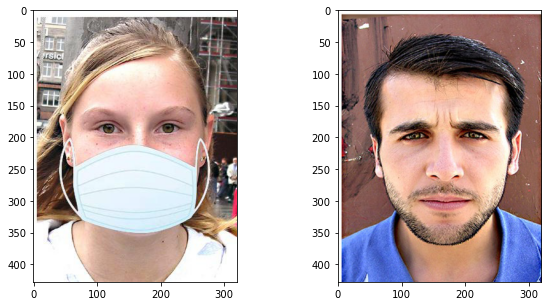

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

with_mask = plt.imread('./maskdata/train/with_mask/100-with-mask.jpg')
without_mask = plt.imread('./maskdata/train/without_mask/101.jpg')

ax[0].imshow(with_mask)
ax[1].imshow(without_mask)
plt.show()

In [3]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
tensorflow.keras.__version__

'2.3.0-tf'

In [4]:
input_size = (224, 224)

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    'maskdata/train',
    batch_size=64,
    class_mode='categorical',
    target_size=input_size)

Found 616 images belonging to 2 classes.


In [6]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_generator = valid_datagen.flow_from_directory(
    'maskdata/test',
    shuffle=False,
    class_mode='categorical',
    target_size=(input_size)
)

Found 198 images belonging to 2 classes.


In [7]:
conv_base = ResNet50(include_top=False, weights='imagenet')

In [8]:
for layer in conv_base.layers:
    layer.trainable = False

In [9]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)

prediction_layer = layers.Dense(2, activation='softmax', name='fc2')(x)

In [10]:
model = Model(conv_base.input, prediction_layer)

In [11]:
#model.summary()

In [12]:
opt = Adam()

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    epochs=3,
    validation_data=valid_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
10/10 [==============================] - 18s 2s/step - loss: 0.5587 - accuracy: 0.7338 - val_loss: 0.1724 - val_accuracy: 0.9697
Epoch 2/3
10/10 [==============================] - 17s 2s/step - loss: 0.0903 - accuracy: 0.9854 - val_loss: 0.0683 - val_accuracy: 0.9899
Epoch 3/3
10/10 [==============================] - 17s 2s/step - loss: 0.0338 - accuracy: 0.9935 - val_loss: 0.0396 - val_accuracy: 0.9949


In [15]:
model.save('models/ResNet50_Transfer_model.h5')
model.save_weights('models/ResNet50_Transfer_weights.h5')

In [16]:
train_generator.n, valid_generator.n

(616, 198)

In [17]:
labels = {'with_mask': 0, 'without_mask': 1}
labels

{'with_mask': 0, 'without_mask': 1}

In [18]:
from tensorflow.keras.models import load_model, model_from_json
model = load_model("models/ResNet50_Transfer_model.h5")

In [19]:
from PIL import Image
import numpy as np

test_image_paths = ['with_mask.jpg', 'without_mask.jpg']

In [20]:
image_list = [Image.open(image_path) for image_path in test_image_paths];
image_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=660x370 at 0x7F2ED8110850>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x450 at 0x7F2ED8110CA0>]

In [21]:
image_size = (224, 224)
validation_batch = np.stack([preprocess_input(np.array(img.resize(image_size))) for img in image_list])
validation_batch.shape

(2, 224, 224, 3)

In [22]:
pred_probs = model.predict_on_batch(validation_batch)
pred_probs

array([[0.97498757, 0.02501236],
       [0.06213047, 0.93786955]], dtype=float32)

In [23]:
np.argmax(pred_probs, axis=1)

array([0, 1])

In [24]:
labels

{'with_mask': 0, 'without_mask': 1}

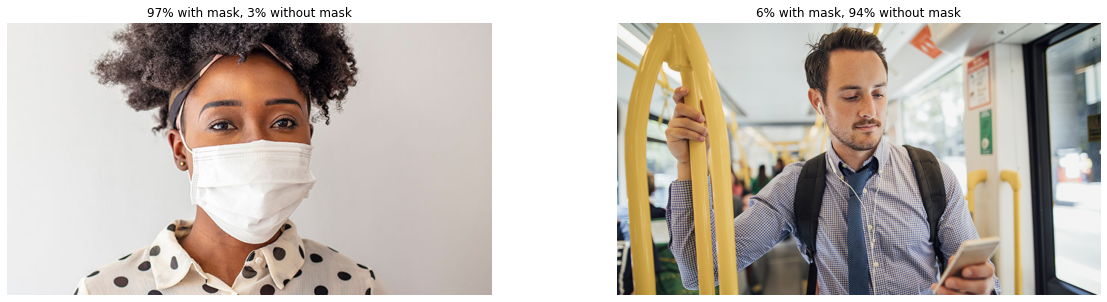

In [25]:
fig, axs = plt.subplots(1, len(image_list), figsize=(20, 5))

for i, img in enumerate(image_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(f"{100*pred_probs[i,0]:.0f}% with mask, {100*pred_probs[i,1]:.0f}% without mask")
    ax.imshow(img)